In [1]:
# 使用models模块创建并训练神经网络模型
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

In [2]:
df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]
df

open    high     low   close  pre_close  change  \
datetime   instrument                                                      
2006-01-04 000001.SZ     6.13    6.33    6.12    6.28       6.14    0.14   
           000002.SZ     4.40    4.67    4.40    4.66       4.31    0.35   
           000012.SZ     4.70    4.75    4.55    4.70       4.62    0.08   
           000016.SZ     3.52    3.58    3.52    3.57       3.52    0.05   
           000021.SZ     7.99    8.40    7.99    8.32       8.00    0.32   
...                       ...     ...     ...     ...        ...     ...   
2022-12-30 688363.SH   136.00  137.00  131.50  135.28     135.49   -0.21   
           688396.SH    53.06   53.40   52.49   52.65      52.87   -0.22   
           688561.SH    65.49   67.88   64.85   65.77      65.46    0.31   
           688599.SH    63.31   64.56   62.31   63.76      63.20    0.56   
           688981.SH    41.01   41.35   41.01   41.14      40.89    0.25   

                       pct_chg        vol       amount  mean_price  
datetime   instrument                                               
2006-01-04 000001.SZ    2.2800  154450.68   96989.0066    6.279610  
           000002.SZ    8.1200  389310.43  175187.0657    4.499933  
           000012.SZ    1.7300   40399.61   18863.8625    4.669318  
           000016.SZ    1.4200   14426.65    5131.8793    3.557222  
           000021.SZ    4.0000   33526.60   27657.1708    8.249322  
...                        ...        ...          ...         ...  
2022-12-30 688363.SH   -0.1550   29951.60  401624.1560  134.091052  
           688396.SH   -0.4161   23401.54  123568.2880   52.803486  
           688561.SH    0.4736   22567.89  149379.0770   66.190981  
           688599.SH    0.8861  109144.36  695759.9350   63.746760  
           688981.SH    0.6114   60396.11  248594.8820   41.160744  

[1199445 rows x 10 columns]

In [3]:
# 构造目标值, 并按照-10% 和10%截断(因为有涨跌停限制)
df["label"] = df["pct_chg"].groupby("instrument").shift(-2)
df = df.dropna()
df["label"].describe()

count    1.197673e+06
mean     5.759776e-02
std      2.858067e+00
min     -4.650000e+01
25%     -1.330000e+00
50%      0.000000e+00
75%      1.370000e+00
max      1.249400e+02
Name: label, dtype: float64

In [4]:
kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
}
X = alpha.make_factors(kwargs=kwargs)
X = pd.concat([X, df[["label"]]], axis=1)
X = X.dropna()
X

time used: 224.69334268569946


DIF       DEA    RET1_1    RET2_1    RET1_2  \
datetime   instrument                                                     
2006-04-13 000001.SZ   0.082792  0.048159  0.018127  0.237705  0.045317   
           000002.SZ   0.308876  0.342051  0.034109  0.467213  0.066667   
           000059.SZ   0.089970  0.084959  0.037037  0.532787  0.049383   
           000061.SZ   0.310305  0.197468  0.039855  0.586066  0.005435   
           000063.SZ   0.433993  0.517134  0.003007  0.163934  0.012028   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   4.732139  3.689427  0.014707  0.757895 -0.044489   
           688396.SH   0.072127  0.480778  0.013962  0.736842 -0.000566   
           688561.SH   0.842230  0.673733  0.021935  0.877193  0.031379   
           688599.SH  -1.572494 -2.529311 -0.038425  0.010526 -0.053571   
           688981.SH   0.029167  0.184851  0.014181  0.747368  0.012958   

                         RET2_2    RET1_3    RET2_3    RET1_4    RET2_4  ...  \
datetime   instrument                                                    ...   
2006-04-13 000001.SZ   0.573770  0.018127  0.336066 -0.022659  0.213115  ...   
           000002.SZ   0.790984  0.040310  0.557377  0.058915  0.819672  ...   
           000059.SZ   0.618852  0.071605  0.815574  0.059259  0.823770  ...   
           000061.SZ   0.184426  0.007246  0.245902  0.009058  0.495902  ...   
           000063.SZ   0.225410  0.020047  0.352459  0.051788  0.778689  ...   
...                         ...       ...       ...       ...       ...  ...   
2022-12-28 688363.SH   0.070175 -0.045297  0.122807 -0.038973  0.136842  ...   
           688396.SH   0.585965 -0.009623  0.487719  0.012264  0.828070  ...   
           688561.SH   0.954386  0.023001  0.950877 -0.051028  0.091228  ...   
           688599.SH   0.042105 -0.140784  0.007018 -0.116550  0.007018  ...   
           688981.SH   0.817544  0.003912  0.757895  0.004156  0.719298  ...   

                       CORRCV10  CORRCV20  CORRCV30  CORRCV60   AMOUNT5  \
datetime   instrument                                                     
2006-04-13 000001.SZ  -1.104650 -1.249570 -1.463733 -1.044095  1.139074   
           000002.SZ  -0.217854 -0.440808 -0.281896 -0.243158  1.194574   
           000059.SZ   0.143769 -0.016791  0.110390  0.163974  1.498461   
           000061.SZ  -0.075133  0.112249  0.248279  0.253330  1.844614   
           000063.SZ  -0.054157 -0.104096  0.037435  0.053793  1.177229   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH  -1.365902 -1.637625 -1.760224 -1.811791  0.391778   
           688396.SH   0.422790  0.124940  0.174181  0.082891  1.674625   
           688561.SH  -1.241557 -1.704082 -2.131163 -2.025677  0.494056   
           688599.SH  -1.414989 -0.806515 -1.176738 -1.453161  0.528563   
           688981.SH   0.307370  0.032351  0.064034  0.025123  1.126837   

                       AMOUNT10  AMOUNT20  AMOUNT30  AMOUNT60   label  
datetime   instrument                                                  
2006-04-13 000001.SZ   0.808621  0.471296  1.349543  1.307721 -0.4400  
           000002.SZ   1.446053  0.678715  0.604166  0.639505 -3.3300  
           000059.SZ   0.615724  0.197315  0.494023  1.417788 -0.4900  
           000061.SZ   0.387233  0.135996  0.205245  0.213659  3.3700  
           000063.SZ   1.163405  0.458922  0.409041  0.469591 -7.4200  
...                         ...       ...       ...       ...     ...  
2022-12-28 688363.SH   0.947322  0.719363  1.316014  0.427300 -0.1550  
           688396.SH   4.719745  1.218943  2.626182  1.643164 -0.4161  
           688561.SH   1.735394  1.894400  1.826660  1.045160  0.4736  
           688599.SH   0.575414  0.813492  0.810529  0.576380  0.8861  
           688981.SH   5.155468  1.256573  3.713760  0.867828  0.6114  

[1137622 rows x 176 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1137622 entries, (Timestamp('2006-04-13 00:00:00'), '000001.SZ') to (Timestamp('2022-12-28 00:00:00'), '688981.SH')
Columns: 176 entries, DIF to label
dtypes: float64(176)
memory usage: 1.5+ GB
None
X_mis= 0.0
clean dataset done 

split data done 

label norm done 

The distribution of y_train:


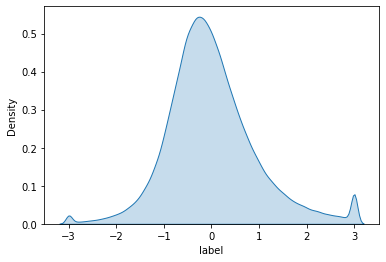

The distribution of y_valid:


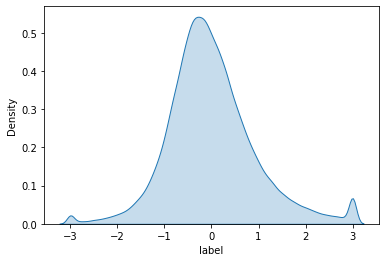

The distribution of y_test:


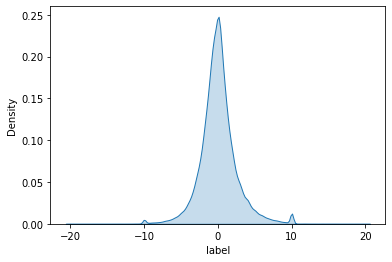

norm data done 

all works done 



In [5]:
split_params = {
    "test_start_date": "2019-01-01",
    "split_method": "group_split",
    "split_kwargs":{
        "train": 0.7,
        "valid": 0.3
    }
}

# 从训练集中按7：3的比例随机拆分出验证集, 并在截面上进行标准化
result = q.auto_process(X, "label", groupby="instrument", split_params=split_params, select=False, orth=False)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"]
X_test, y_test, ymean, ystd = result["X_test"], result["y_test"], result["ymean"], result["ystd"]

In [6]:
from scutquant import models

cnn = models.CNN(epochs=20)
cnn.fit(X_train, y_train, X_valid, y_valid)

pred = cnn.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += ymean.groupby("datetime").shift(2).fillna(0.0002)
pred["predict"] *= ystd.groupby("datetime").shift(2).fillna(0.0189)

pred.describe()

Epoch 1/20
2346/2346 [==============================] - 69s 30ms/step - loss: 0.9390 - mae: 0.7237 - mape: 2506.8809 - val_loss: 0.9070 - val_mae: 0.7117 - val_mape: 618.9734
Epoch 2/20
2346/2346 [==============================] - 70s 30ms/step - loss: 0.8998 - mae: 0.7087 - mape: 1615.1378 - val_loss: 0.9012 - val_mae: 0.7094 - val_mape: 1433.4915
Epoch 3/20
2346/2346 [==============================] - 70s 30ms/step - loss: 0.8913 - mae: 0.7052 - mape: 1575.7595 - val_loss: 0.8921 - val_mae: 0.7052 - val_mape: 936.8768
Epoch 4/20
2346/2346 [==============================] - 70s 30ms/step - loss: 0.8864 - mae: 0.7031 - mape: 814.9664 - val_loss: 0.8856 - val_mae: 0.7010 - val_mape: 788.4663
Epoch 5/20
2346/2346 [==============================] - 70s 30ms/step - loss: 0.8815 - mae: 0.7011 - mape: 1094.6936 - val_loss: 0.8899 - val_mae: 0.7028 - val_mape: 766.3857
Epoch 6/20
2346/2346 [==============================] - 70s 30ms/step - loss: 0.8796 - mae: 0.7001 - mape: 1041.7866 - val_lo

,predict
count,280150.000000
mean,-0.000249
std,0.002482
min,-0.040495
25%,-0.001633
50%,-0.000290
75%,0.001083
max,0.021970


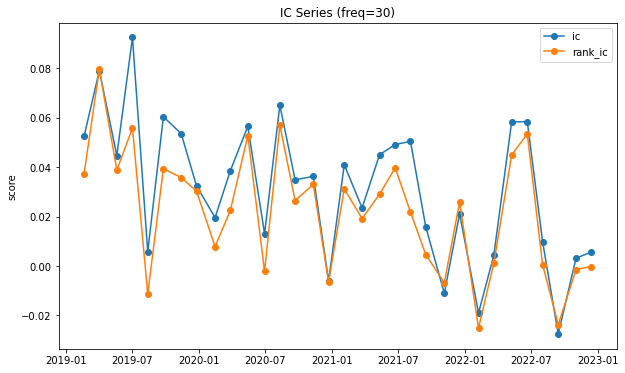

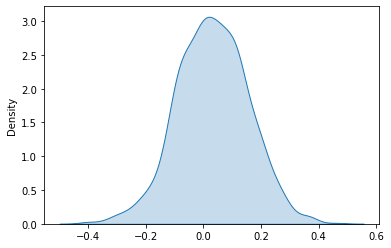

ic= 0.031311469867054 icir= 0.2530230339168426 rank_ic= 0.02209681384217421 rank_icir= 0.17928800021312993


0.027948376863424645

In [7]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred.values, y_test)
r[0]

In [8]:
model = cnn.model
print(model.summary())
#model.save("attention")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 56, 32)            320       
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 55, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 64)            14400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

Accuracy of Prediction: 0.5283808134546079


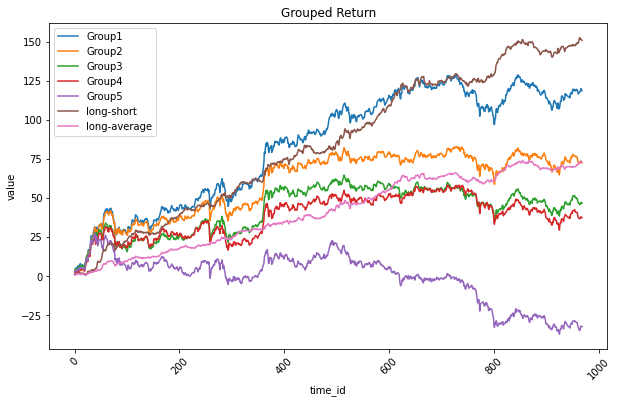

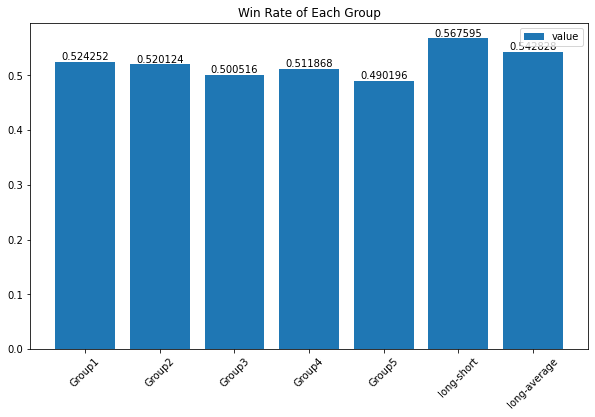

In [9]:
df_test = df[df.index.get_level_values(0) >= "2019-01-01"]
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
report.group_return_ana(pred, y_test)

In [10]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前20%股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 500, # 融券做空的数量
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.25  # 手数随可用资金而改变，最大不会超过股票当天成交量的1%(例如T+1时下单，下单手数不会超过T时成交量的1%)
        }
    },
    "account": None, # 使用默认账户, 即初始资金为1亿, 无底仓 (注意策略容量！)
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0015,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: 0.11501668006041643
Annualized Volatility: 0.3501273365824329
Annualized Return(Benchmark): 0.07903465509941188
Annualized Volatility(Benchmark): 0.33918455897903593 

Cumulative Rate of Return: 0.5198758102889016
Cumulative Rate of Return(Benchmark): 0.3397659986073198
Cumulative Excess Rate of Return: 0.1801098116815818 

Max Drawdown: -0.35993502910708375
Max Drawdown(Benchmark): -0.5464988056952731
Max Drawdown(Excess Return): -0.1991854528232635 

Sharpe Ratio: 2.706262746399624
Sortino Ratio: 0.2610030369414287
Information Ratio: 0.3842604220480838 

Beta: 0.9776601909808259
Alpha: 0.07787426291107769
Epsilon: 0.057301719981581664
Profitable Days(%): 0.8864809081527347


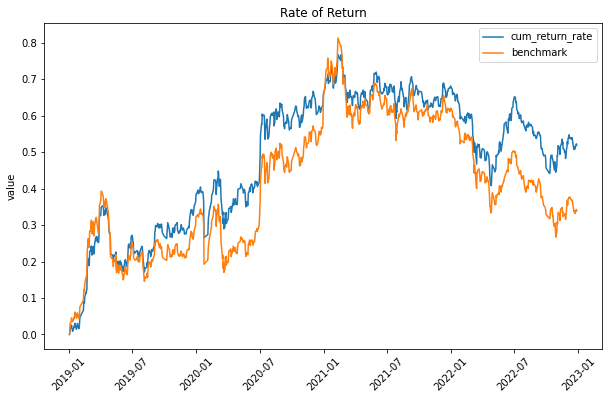

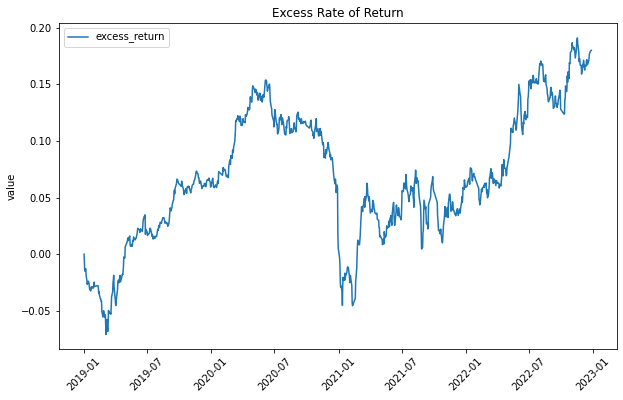

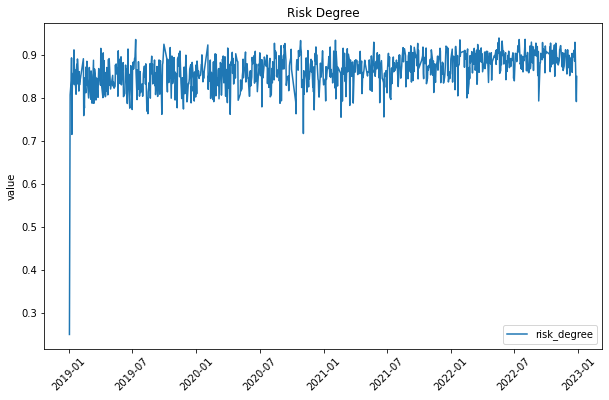

In [11]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节